In [1]:
# Third Party Imports
import pandas as pd
import sklearn
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

import bat
from bat import log_to_dataframe
from bat import dataframe_to_matrix
print('DONE')

DONE


In [2]:
# Create a Pandas dataframe from a Bro log
bro_df = log_to_dataframe.LogToDataFrame('/home/dane/bro_logs/100k_dnsonly.log')

# Print out the head of the dataframe
bro_df.head()
print('DONE')

Successfully monitoring /home/dane/bro_logs/100k_dnsonly.log...
DONE


In [3]:
# Using Pandas we can easily and efficiently compute additional data metrics
# Here we use the vectorized operations of Pandas/Numpy to compute query length
bro_df['query_length'] = bro_df['query'].str.len()
print('DONE')
bro_df.head()
#print(bro_df['id.resp_p'])

DONE


,AA,RA,RD,TC,TTLs,Z,answers,id.orig_h,id.orig_p,id.resp_h,...,qtype,qtype_name,query,rcode,rcode_name,rejected,rtt,trans_id,uid,query_length
ts,,,,,,,,,,,,,,,,,,,,,
2018-12-07 21:00:00.098604,False,False,False,False,-,0,-,192.168.230.115,45541,192.168.196.52,...,0,-,-,3,NXDOMAIN,False,0 days,39509,CIHzuU1CZBR1VwXJf8,1
2018-12-07 21:00:01.239240,False,False,False,False,-,0,-,192.168.230.137,54504,192.168.196.52,...,0,-,-,3,NXDOMAIN,False,0 days,49641,CJUNRuZ0jbCbtiyRj,1
2018-12-07 21:00:01.821986,False,False,False,False,-,0,-,192.168.230.135,44810,192.168.196.52,...,0,-,-,3,NXDOMAIN,False,0 days,50003,Co1wIi2KlwgLBnn2Gb,1
2018-12-07 21:00:00.122574,False,False,False,False,-,0,-,192.168.230.115,40547,192.168.196.52,...,0,-,-,3,NXDOMAIN,False,0 days,39098,CokYLVSPhJrDtT3kk,1
2018-12-07 21:00:00.130560,False,False,False,False,-,0,-,192.168.230.115,59178,192.168.196.52,...,0,-,-,3,NXDOMAIN,False,0 days,40814,C6SMF13vvOWwaWcTOh,1


## DNS records are a mix of numeric and categorical data
When we look at the dns records some of the data is numerical and some of it is categorical so we'll need a way of handling both data types in a generalized way. bat has a DataFrameToMatrix class that handles a lot of the details and mechanics of combining numerical and categorical data, we'll use below.

In [4]:
# These are the features we want (note some of these are categorical :)
features = ['query', 'qclass_name', 'qtype_name', 'rcode_name',]
feature_df = bro_df[features]
feature_df.head()
print('DONE')

DONE


In [5]:
# Use the bat DataframeToMatrix class (handles categorical data)
# You can see below it uses a heuristic to detect category data. When doing
# this for real we should explicitly convert before sending to the transformer.
to_matrix = dataframe_to_matrix.DataFrameToMatrix()
bro_matrix = to_matrix.fit_transform(feature_df)
print('DONE')

Changing column qclass_name to category...
Changing column qtype_name to category...
Changing column rcode_name to category...
DONE


In [6]:
# Just showing that the class is tracking categoricals and normalization maps
print(to_matrix.cat_columns)
print(to_matrix.norm_map)
print('DONE')

['qclass_name', 'qtype_name', 'rcode_name']
{}
DONE


In [7]:
# Now we're ready for scikit-learn!
# Just some simple stuff for this example, KMeans and TSNE projection
kmeans = KMeans(n_clusters=3).fit_predict(bro_matrix)
projection = TSNE().fit_transform(bro_matrix)
print('DONE')

DONE


DONE


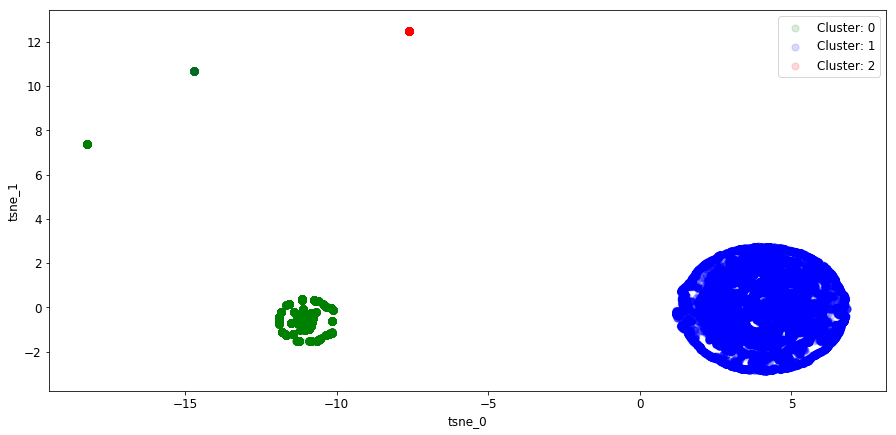

In [18]:
# Now we can put our ML results back onto our dataframe!
bro_df['tsne_0'] = projection[:, 0] # Projection X Column
bro_df['tsne_1'] = projection[:, 1] # Projection Y Column
bro_df['cluster'] = kmeans
bro_df[['query', 'proto', 'tsne_0', 'tsne_1', 'cluster']].head()  # Showing the scikit-learn results in our dataframe
# Plotting defaults
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 12.0
plt.rcParams['figure.figsize'] = 15.0, 7.0
# Now use dataframe group by cluster
cluster_groups = bro_df.groupby('cluster')

# Plot the Machine Learning results
fig, ax = plt.subplots()
colors = {0:'green', 1:'blue', 2:'red'}#, 3:'orange', 4:'purple',}
for key, group in cluster_groups:
    group.plot(ax=ax, kind='scatter', x='tsne_0', y='tsne_1', alpha=0.15, s=50,
               label='Cluster: {:d}'.format(key), color=colors[key])
print('DONE')

In [15]:
# Now print out the details for each cluster
pd.set_option('display.width', 1000)
show_fields = ['query', 'Z', 'proto', 'qtype_name', 
               'cluster','AA', 'RA', 'RD',
               'TC', 'rejected','qclass_name',
               'rcode_name', 'query_length']
for key, group in cluster_groups:
    print('\nCluster {:d}: {:d} observations'.format(key, len(group)))
    print(group[show_fields].head())
print(len(bro_df))
# Cluster 0 = normal query
# Cluster 1 = successful dns query to the "internet" by an HP laserjet printer
# Cluster 2 = blank query without query type and length of 1
# Cluster 3 = normal successful dns query to the "internet"
# Cluster 4 = variable query_length, successful dns query of type PTR - Reverse-lookup Pointer records (PTR Record)—allows a DNS resolver to provide an IP address and receive a hostname (reverse DNS lookup).
print('DONE')


Cluster 0: 18059 observations
                           query  Z proto qtype_name  cluster     AA     RA     RD     TC  rejected qclass_name rcode_name  query_length
ts                                                                                                                                      
2018-12-07 21:02:35.658595     -  0   udp          -        0  False  False  False  False      True           -   SERVFAIL             1
2018-12-07 21:02:35.666563     -  0   udp          -        0  False  False  False  False      True           -   SERVFAIL             1
2018-12-07 21:02:35.658595     -  0   udp          -        0  False  False  False  False      True           -   SERVFAIL             1
2018-12-07 21:02:35.666563     -  0   udp          -        0  False  False  False  False      True           -   SERVFAIL             1
2018-12-07 21:02:35.666563     -  0   udp          -        0  False  False  False  False      True           -   SERVFAIL             1

Cluster 1

In [23]:
for key, group in cluster_groups:
    print('\nCluster {:d}: {:d} observations'.format(key, len(group)))
    print(group[show_fields])
print('DONE')



Cluster 0: 18059 observations
                                            query  Z proto qtype_name  cluster     AA     RA     RD     TC  rejected qclass_name rcode_name  query_length
ts                                                                                                                                                       
2018-12-07 21:02:35.658595                      -  0   udp          -        0  False  False  False  False      True           -   SERVFAIL             1
2018-12-07 21:02:35.666563                      -  0   udp          -        0  False  False  False  False      True           -   SERVFAIL             1
2018-12-07 21:02:35.658595                      -  0   udp          -        0  False  False  False  False      True           -   SERVFAIL             1
2018-12-07 21:02:35.666563                      -  0   udp          -        0  False  False  False  False      True           -   SERVFAIL             1
2018-12-07 21:02:35.666563                   

In [25]:
for row in cluster_groups:
    print(row)

(0,                                AA     RA     RD     TC TTLs  Z answers        id.orig_h  id.orig_p       id.resp_h   ...     rcode rcode_name  rejected    rtt  trans_id                 uid query_length     tsne_0     tsne_1  cluster
ts                                                                                                                   ...                                                                                                                
2018-12-07 21:02:35.658595  False  False  False  False    -  0       -  192.168.230.115      57468  192.168.196.52   ...         2   SERVFAIL      True 0 days     36391  Cnwt662Mz0rJu8xkXk            1 -11.798269  -1.097409        0
2018-12-07 21:02:35.666563  False  False  False  False    -  0       -  192.168.230.115      57468  192.168.196.52   ...         2   SERVFAIL      True 0 days     36391  Cnwt662Mz0rJu8xkXk            1 -11.798269  -1.097409        0
2018-12-07 21:02:35.658595  False  False  False  False    -  0  